<span style='font-family:Times New Roman'> Damian Kokot 426349 </span>

<h1 style='font-family:Times New Roman;text-align:center'>Abstract</h1>

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Data augmentation is a set of techiques to increase the amount of data. It generates new feature points from existing data by applying specific methods. For example noisy audio data can be synthetised by superimposing clean audio with a noisy audio signal in. Here, SpecAugment [1] and adding noise methods are implemented to the data provide by Oxford Nanopore Technologies (ONT) sequencing. Agumented data is then pass through RODAN [2] model to fit it and RNA basecaller is call out at the end of the pipeline. The aim of this work is to check how augmentation on data from ONT influence the basecaller performance by evaluating its accuracy.</p>

# Introduction 

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Oxford Nanopore Technologies gives an oppurtinity to increase ability to sequence DNA and RNA directly without requiring amplification, producing long reads that can help identify splice isofroms unambiguously, determine poly(A) length, and can potentially capture information on base modifications. All methods of ONT have the same core, it records disturbance in electric current that goes along membrane caused by RNA/DNA sequence (passing through the membrane) that 'cuts' the current. The technology offers well performed sequencing method, although it is hampered by high error rates. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Translating current signal to DNA or RNA (basecalling) if very challenging. This case has several factors, for example, signal for each nucleotide is affected by surrounding bases thus to each nucleotides variable number of sequence values is assign, also such current signal are just simply noisy [3]. Given that there is a wide spectrum to improve basecallers. One of basecallers with state-of-the-art accuracy is Bonito [4] which is based on convolutional neural network (CNN) architecture. This model improve basecalling for DNA, but there is still little attention to RNA basecallers. However RODAN [2] undertakes the chalenge and perform very well with RNA data. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'>Although RODAN basecaller gives good results, the model have to be fit with big amount of data, which makes the training time long. Data augmentation might be perfect solution to reduce time of the training and with keeping, or even improving, accuracy of basecaller. Augementation deals well with uneven class balance within the datasets or small amount of data. It produces new and different examples to train datasets[5]. Here, newly formed data replace some examples from training and validation dataset, so amount of the data does not increase. Thus it will be examined if on reduce data with some augmentation model can fit well and give imporoved accuracy. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'>In this work data augmentation is focused on two approaches: first is simple method that is based on adding the noise to the signal and second one is SpecAugment with an emphasis on time masking [1]. Two RODAN models were fitted each on seperate augmented dataset. Then models were compared with each other. RODAN basecaller is CNN model built with PyTorch library. </p>

# Materials and methods 

## Methods 

### Basecaller Architecture

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Core of the model that creates RODAN basecaller is convolutional neural network that is focused on 1D convolution layers. Model is fitted with augement data and learn to predict signals from ONT sequencers. The output of the model are vectors with values from 0 to 5 that represents five symbols 'ACTGN'. The vector is then translated to RNA sequence. Detailed architecture is described in original RODAN project [2, 6]. </p>

### Augementation 

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Data augmentation was focus on Time Masking that comes from SpecAugment methods [1] and adding so-called 'white-noise'. 'White noise' was simulated by adding to each element of the read, value from normal distribution with 0 mean and 1 standard deviation multiply by 0.009 factor which is enough for augmentation. Sometimes data augmentation can be too robust and lead to high training loss values thus poor model fitting.</p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Here, the use of SpecAugment implementation in DNA/RNA basecallers was inspired by Fast-Bonito work [7], which gives good results and points good arguments to apply dna augmentation in such models. However, there are lacks in source code of Fast-Bonito project, specific for data augmentation and model architecture, both in paper and GitHub repository [8]. So here, in this work, custom TimeMasking augementation from SpecAugment work is implemented. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> SpecAugment method is based on image data augmentation, so instead of applying conventional methods to raw audio input (data from ONT sequencers, which are vectors with signal values, can be treated as raw audio data in waveform format [Fig. 1]) the method transforms waveform to spectrogram [Fig.3] (vector to image) and then applies augmentation to it. This approach intoduce less computational cost and does not require additional data compared to conventional methods. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'>Here, RODAN model is fitted with time-masking augmented data [Fig. 4]. It consists masking t consecutive time steps [t0, t0+t) where t is chosen from
a uniform distribution from 0 to the time mask parameter T , and t0 is chosen from [0, τ − t) [1]. Augmented spectrogram is then inverted to waveform so that it fits RODAN model input shape. Transformation waveform-sepctrogram-waveform and augmentation was made with the use of PyTorch package Transorfm and its methods.</p>

In [47]:
import h5py
import numpy as np
from ont_fast5_api.fast5_interface import get_fast5_file

In [3]:
h5 = h5py.File('/home/dkokot/augment_basecallers/data/reduce-train-rna.hdf5', "r")
file = '/home/dkokot/augment_basecallers/data/reduce-train-rna.hdf5'

In [4]:
import spectogram

In [37]:
import librosa
import matplotlib.pyplot as plt

def plot_waveform(waveform, title=None, ):
    fig, axs = plt.subplots(1,1)
    axs.set_title(title ,y=-0.2 )
    axs.set_ylabel('Amplitude')
    axs.set_xlabel('Chunks')
    plt.plot(waveform)
    plt.show()
    
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram", y=-0.2)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("time")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader

import model as md
import model_with_aug as mdaug

data = md.dataloader(recfile=file, seq_len=4096, elen=420)

data_loader = DataLoader(dataset=data, batch_size=1, shuffle=True, num_workers=8, pin_memory=False)

events = []
for i, (event, event_len, label, label_len) in enumerate(data_loader):
    if i < 2:
        events.append(event)
    else: break

Dataloader total events: 10000 seqlen: 4096 event len: 420


In [24]:
# extract read example from raw data
waveform = events[0].numpy()[0]

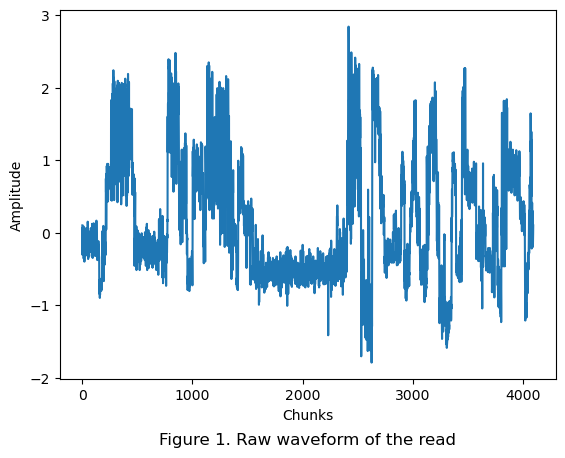

In [25]:
plot_waveform(waveform, 'Figure 1. Raw waveform of the read')

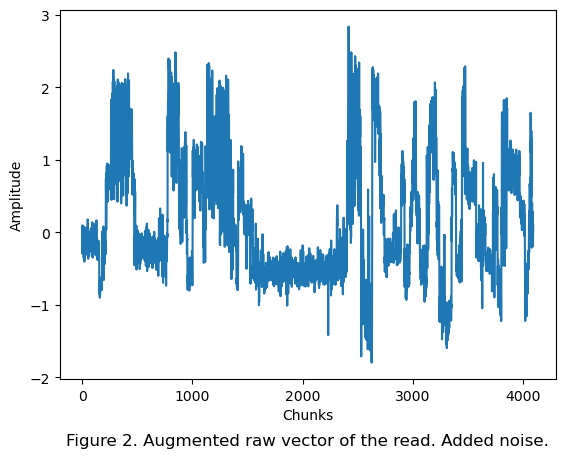

In [27]:
# add 'white-noise'
aug_wv = waveform + 0.009*np.random.normal(0,1,len(waveform))
plot_waveform(aug_wv, 'Figure 2. Augmented raw vector of the read. Added noise.')

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Figure does not show any differance. It is because of the small values of noise that is added to each element of the raw waveform. However the augment can be notice directly in values of the vector. </p>

In [35]:
print('RAW DATA')
print(waveform[0:10])
print('\n')
print('ADDED NOISE')
print(aug_wv[0:10])

RAW DATA
[ 0.10153624 -0.30460873 -0.1958199  -0.18856731  0.07252589 -0.12329401
 -0.23208284 -0.29010355  0.03626294 -0.01450518]


ADDED NOISE
[ 0.09417096 -0.29502836 -0.19273323 -0.19198499  0.08369819 -0.12981212
 -0.23051015 -0.2935271   0.04473217 -0.01299221]


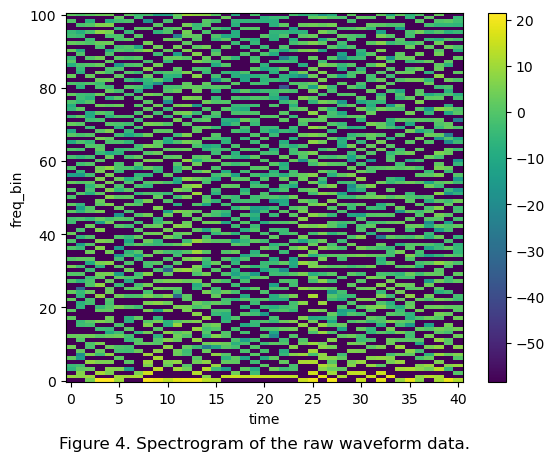

In [39]:
# Displaying spectrogram and augmentation of it
spec = spectogram.get_spectrogram(events[0])
spec_time_mask = spectogram.time_masking(events[0])
plot_spectrogram(spec[0], title='Figure 3. Spectrogram of the raw waveform data.')

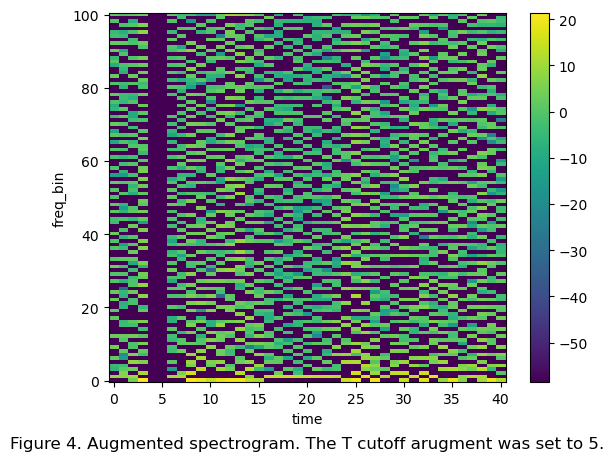

In [41]:
plot_spectrogram(spec_time_mask[0], title='Figure 4. Augmented spectrogram. The T cutoff arugment was set to 5.')

### Fitting the model, basecall and evaluate

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> The RODAN model is then fitted with augmented data. It is necessery to invert spectrogram to waveform, if not some errors can occur during training. The result of the training is model structure with best weights and the model is then used to basecall the test data. From this, predicted sequences are formed which are then aligned with v33 of the gencode[9] via MiniMap2 tool. This results with SAM file which is used to evalute the basecaller as in origin RODAN work. </p>

## Data

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> The RNA training data is composed from multiple spieces such as: human, arabidopsis, mouse, yeast and black cottonwood. It gives variety of data which make model resistant to deviation of the data that is provided during basecall process. Here, test data only contains human reads. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> RNA sequnece from those species were was sequenced on a SpotON R9.4.1 FLO-MIN106 flowcell, using a GridION x5 sequencer. Then, reads were basecalled with Guppy, folowed by Tombo to check quality of the electric current. It is done by assessing signal matching score (SMS) against expected signal. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Reads are stored in HDF5 file. Each read had a random starting point with value between 0 to 1024 signal values, and then segmented into chunks of 4096 values where only chunks with a maximum of 15 samples per base were selected. Such read are then split to dataset of 1000000 training chunks, 100000 chunks for validation and test. Here, training data and validation data is reduced to 10% to accelerate the training process. All data was downloaded from https://zenodo.org/record/4556951. More details about how data is created are described in original RODAN work.</p>

# Results and discussion

## Model training 

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Training was performed with augmented data via adding noise and Time Masking from SpecAugment method. For comparision also training of the original model on reduced data was performed. Evaluation of the the original model gave treshold accuracy of 0.76 and the validation loss (which in this work was more important than training loss) was about 0.5 during training . Given that the aim of my work was to outperform the threshold by augment the input data. First approach to examine how well model perfomed was to compare validation loss of model fitted on noise data and time masked data. Respectively the metrics equaled 0.761 and 0.687, both values were obtained after 13-14 epochs (training and validtion losses for each epoch are presented in project repository https://github.com/damkokot/augment_basecallers). </p>

## Evaluation

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> After the training models were evaluate as in original RODAN work. The results are presented as follows. </p>

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Evalution of the model fitted on noisy data.</p>

In [45]:
import os
os.system('python /home/dkokot/augment_basecallers/src/accuracy.py /home/dkokot/augment_basecallers/results/aug_simple.sam /home/dkokot/augment_basecallers/gencode.v36.transcripts.fa')

Total: 1 Median accuracy: 0.7203087885985748 Average accuracy: 0.7203087885985748 std: 0.0
Median  - Mismatch: 0.05997624703087886 Deletions: 0.20902612826603326 Insertions: 0.010688836104513063
Average - Mismatch: 0.05997624703087886 Deletions: 0.20902612826603326 Insertions: 0.010688836104513063


0

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Evalution of the model fitted on time masked data.</p>

In [46]:
os.system('python /home/dkokot/augment_basecallers/src/accuracy.py /home/dkokot/augment_basecallers/results/spec_aug.sam /home/dkokot/augment_basecallers/gencode.v36.transcripts.fa')

Total: 1 Median accuracy: 0.6788526434195725 Average accuracy: 0.6788526434195725 std: 0.0
Median  - Mismatch: 0.05511811023622047 Deletions: 0.20584926884139482 Insertions: 0.06017997750281215
Average - Mismatch: 0.05511811023622047 Deletions: 0.20584926884139482 Insertions: 0.06017997750281215


0

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Both model performed worse than the original model in training and during evalution. Gentle augmentation, like adding small values of noise to the data, seems to perform better than model fitted with SpecAugment data. Thus, any deviation in values of the data in this work cause basecaller to predict less accurate sequences. This might be due the fact, that augementation was done on already preprocessed data. Normalization was provided as a test case, but this did not give any better performance. Adding augmented data to dataset instead of replacing some examples probably is better approach to fit model. For spectrogram, instead of inverintg it to waveform, passing it to the model would help to outperform original model. This however force to add 2d convolutional layers to the architecture, wich increase number of parameters and the time of the training. Nevertheless, augmentation of the data from this scenerio seems to be not robust reinforcement for basecaller accuracy. </p>

# Conclusion

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Augmentation of the data from ONT sequencers to fit basecallers models for sure helps to increase accuracy of basecaller prediction [7]. Preprocessing raw data from sequencer as in RODAN may bias the augmentation so ultimately adding noise or time masking is not suitable to this scenerio. Here different strategy for the architecture may improve the results but at the expense of training time. Reducing the data from RODAN project to reasonable sizes and adding augmentation as in my project also gives hope to outperfom original accuracy.</p>

# References 
1. .S. Park, et al. SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition Interspeech (2019), pp. 2613-2617,

2. Neumann D et al. RODAN: a fully convolutional architecture for basecalling nanopore RNA sequencing data. 2022. BMC Bioinformatics 23, 142

3. Amarasinghe SL, Su S, Dong X, Zappia L, Ritchie ME, Gouil Q. Opportunities and challenges in long-read sequencing data analysis. Genome Biol. 2020;21(1):1–16.

4. https://github.com/nanoporetech/bonito

5. Mikołajczyk A, Grochowski M. Data augmentation for improving deep learning in image classification problem. IEEE. 2018. 10.1109/IIPHDW.2018.8388338

6. https://github.com/biodlab/RODAN

7. Xu Z. et al.Fast-bonito: A faster deep learning based basecaller for nanopore sequencing. 2021. Artificial Intelligence in the Life Sciences 1: 2667-3185

8. https://github.com/EIHealth-Lab/fast-bonito

9. Frankish A, Diekhans M, Ferreira A-M, Johnson R, Jungreis I, Loveland J, Mudge JM, Sisu C, Wright J, Armstrong J, et al. Gencode reference annotation for the human and mouse genomes. Nucleic Acids Res. 2019;47(D1):766–73